# TODO
Specif Sensiti - trafnosci w poszczegolnych klasach naczynia tło, Prec - ... miary
porównanie sato z machine learning


# Segmenting Retinal Blood Vessels With Deep Neural Networks


In [1]:
import skimage as ski
from skimage import io, exposure, data, color, data, filters, graph, measure, morphology
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from scipy import ndimage as ndi
import cv2

from imblearn.metrics import classification_report_imbalanced

from image_processing import *
from functions import *

filename = 'Data/01_dr.jpg'
mask_filename = 'Data/01_dr_mask.tif'
manual_filename = 'Data/01_dr.tif'

image = loadImage(filename)
mask = loadImageTif(mask_filename)
manual = loadImageTif(manual_filename)

# Sato filter

In [ ]:
_, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
_ = ax.set_title('Human retina')

retina = color.rgb2gray(image)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)	#dont override vessels
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')


Extract vessels from retina image


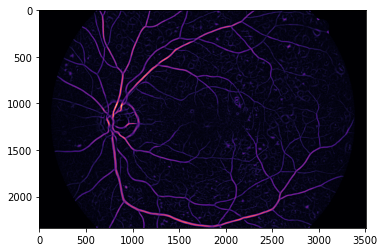

Add contrast and threshold to highlight vessels


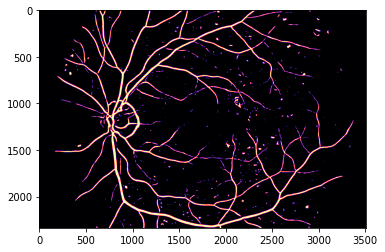

In [3]:
vessels = extract_vessels(image)
print("Extract vessels from retina image")
showImage(vessels, cmap='magma')
vessels = contrast(vessels)
vessels = threshold(vessels)
print("Add contrast and threshold to highlight vessels")
showImage(vessels, cmap='magma')

# Comparing vessels 

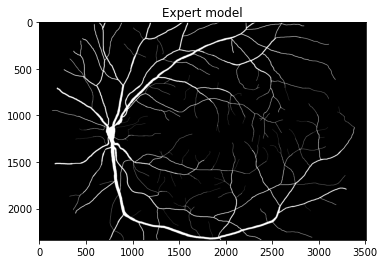

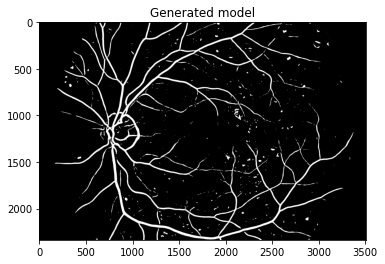

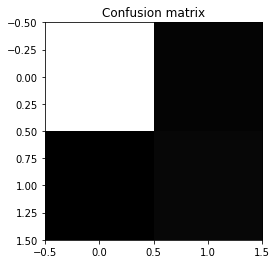

Confusion matrix: [7537842  231220  101964  314318]

Main metrics:
Accuracy score:		 0.959295
Sensitivity score:	 0.755060
Specificity score:	 0.970238
Precision score:	 0.576162
G-mean: 		 0.855914
Weighted average: 	 0.862649

Classification report with sklearn.metrics
              precision    recall  f1-score   support

  background       0.99      0.97      0.98   7769062
     vessels       0.58      0.76      0.65    416282

    accuracy                           0.96   8185344
   macro avg       0.78      0.86      0.82   8185344
weighted avg       0.97      0.96      0.96   8185344


Classification report with imblearn.metrics
                   pre       rec       spe        f1       geo       iba       sup

 background       0.99      0.97      0.76      0.98      0.86      0.75   7769062
    vessels       0.58      0.76      0.97      0.65      0.86      0.72    416282

avg / total       0.97      0.96      0.77      0.96      0.86      0.75   8185344



In [37]:
y_pred = vessels.flatten()		# True - żyły, False - tło
y_true = manual.flatten()		# 255 - żyły, 0 - tło
model_mask = (y_true > 0)		# maska pikseli, które reprezentują żyły w modelu ekspertskim

y_true_masked = np.zeros(y_true.shape, dtype=bool)		# utworzenie maski True/False dla modelu ekspertskiego
y_true_masked[model_mask] = True

showImage(y_true_masked.reshape(vessels.shape), title="Expert model")
showImage(y_pred.reshape(vessels.shape), title="Generated model")
showImage(metrics.confusion_matrix(y_true_masked.flatten(), y_pred.flatten()), title="Confusion matrix")
print("Confusion matrix:", metrics.confusion_matrix(y_true_masked.flatten(), y_pred.flatten()).flatten(), end="\n\n")


# tn, fp, fn, tp = confusion_matrix(y_true_masked, y_pred).ravel()
# specificity = tn / (tn+fp)												# daje ten sam rezultat co recall_score(y_true_masked, y_pred, pos_label=0)


# Compare 5 images using non-machine learning methods (sato filter)

----------------------------------
Retina number:  1
----------------------------------


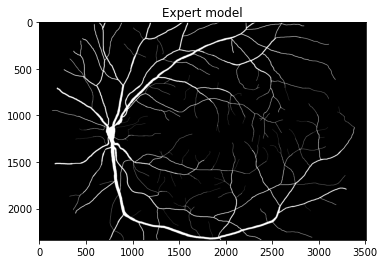

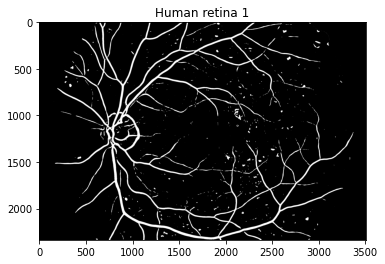

Accuracy score:		 0.959295
Sensitivity score:	 0.755060
Specificity score:	 0.970238
Precision score:	 0.576162
G-mean: 		 0.855914
Weighted average: 	 0.862649
----------------------------------
Retina number:  2
----------------------------------


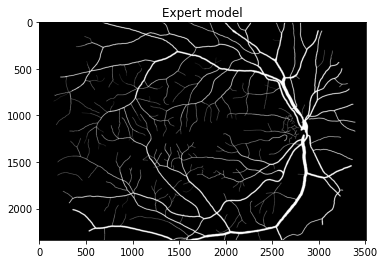

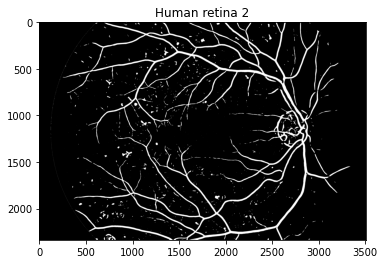

Accuracy score:		 0.955742
Sensitivity score:	 0.719289
Specificity score:	 0.971845
Precision score:	 0.635004
G-mean: 		 0.836084
Weighted average: 	 0.845567
----------------------------------
Retina number:  3
----------------------------------


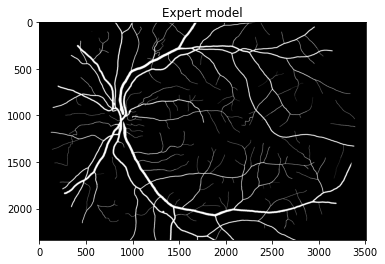

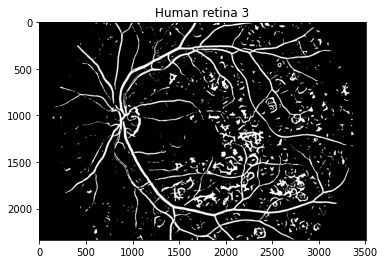

Accuracy score:		 0.921585
Sensitivity score:	 0.744557
Specificity score:	 0.932965
Precision score:	 0.416566
G-mean: 		 0.833454
Weighted average: 	 0.838761
----------------------------------
Retina number:  4
----------------------------------


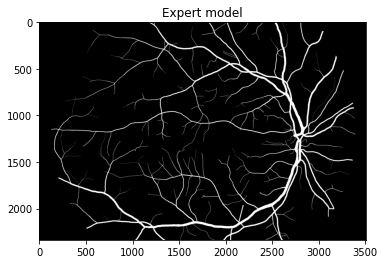

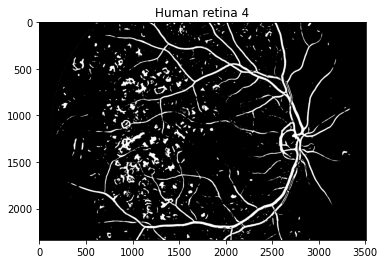

Accuracy score:		 0.937877
Sensitivity score:	 0.680282
Specificity score:	 0.953292
Precision score:	 0.465698
G-mean: 		 0.805300
Weighted average: 	 0.816787
----------------------------------
Retina number:  5
----------------------------------


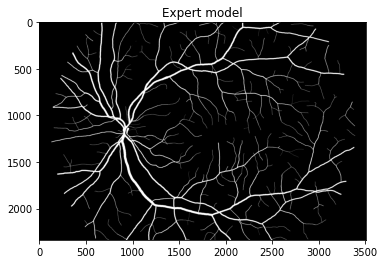

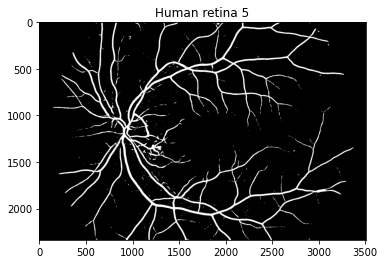

Accuracy score:		 0.963099
Sensitivity score:	 0.789136
Specificity score:	 0.974633
Precision score:	 0.673490
G-mean: 		 0.876994
Weighted average: 	 0.881885
----------------------------------
Retina number:  6
----------------------------------


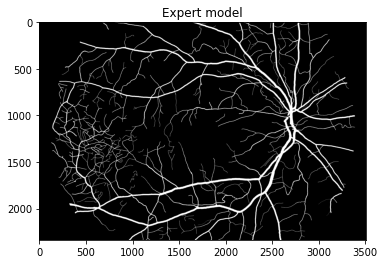

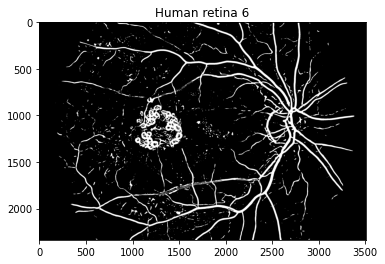

Accuracy score:		 0.936344
Sensitivity score:	 0.642916
Specificity score:	 0.960306
Precision score:	 0.569460
G-mean: 		 0.785745
Weighted average: 	 0.801611


In [4]:
number_of_images = 5

for number in range(1,number_of_images+2):
	# import files
	filenameN = 'Data/0' + str(number) + '_dr.jpg'
	mask_filenameN = 'Data/0' + str(number) + '_dr_mask.tif'
	manual_filenameN = 'Data/0' + str(number) + '_dr.tif'	
	imageN = loadImage(filenameN)
	maskN = loadImageTif(mask_filenameN)
	manualN = loadImageTif(manual_filenameN)

	vesselsN = extract_and_use_vessels(imageN)

	print("----------------------------------")
	print("Retina number: ", number)
	print("----------------------------------")
	showImage(manualN, title="Expert model")
	showImage(vesselsN, title="Human retina "+str(number))

	stats = {}
	stats['accuracy'], stats['sensitivity'], stats['specificity'], stats['precision'], stats['g_mean'], stats['w_average'], stats['c_matrix'] = get_metrics(vesselsN, manualN)
	show_stats(stats)

# REST

In [ ]:
both_vessels = np.logical_and(vessels, manual)
wrong_vessels = np.logical_xor(vessels, manual)
all_vessels = np.logical_or(vessels, manual)
print("Sensitivity:" , round(sum(both_vessels.flatten() + sum(wrong_vessels.flatten())) / sum(all_vessels.flatten())*100, 3), "%")

<ipython-input-163-5da2418774eb>:4: RuntimeWarning: overflow encountered in scalar add
  print("Sensitivity:" , round(sum(both_vessels.flatten() + sum(wrong_vessels.flatten())) / sum(all_vessels.flatten())*100, 3), "%")


Sensitivity: -12086.966 %


# Machine learning

### Wymagania na 4.0


Po wstępnym przetworzeniu obrazu należy podzielić go na wycinki (np. 5x5 px) i dla każdej z nich dokonać ekstrakcji cech z obrazu: np. wariancja kolorów, momenty centralne, momenty Hu itp. Wartości te wraz z informacją pochodzącą z maski eksperckiej (decyzja dla środkowego piksela wycinka) stanowić będą zbiór danych wykorzystany do budowy wybranego klasyfikatora, prostszego niż głęboka sieć neuronowa (np. kNN, drzewo lub las decyzyjny, SVM). Należy skorzystać z gotowej implementacji klasyfikatora (np. w bibliotece scikit-learn).


Z uwagi na ograniczenia pamięciowe konieczne może być ograniczenie rozmiaru zbioru uczącego poprzez losowy wybór punktów (możliwość zastosowania undersampling-u do zrównoważenia rozkładu klas w zbiorze uczącym).


Zdolności predykcyjne tak opracowanego klasyfikatora należy wstępnie zweryfikować na niezależnym zbiorze testowym hold-out (np. pochodzącym z innej części obrazu lub z innego obrazu). 


Gotowy klasyfikator powinien zostać osadzony w aplikacji, a jego działanie powinno zostać zwizualizowane i przetestowane w taki sam sposób, jak działanie technik przetwarzania obrazu z wymagań podstawowych.


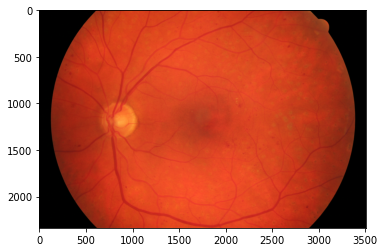

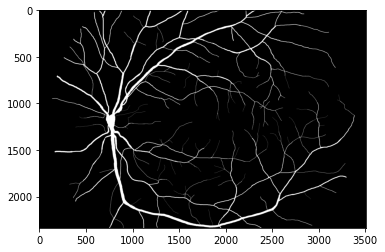

In [44]:
showImage(image)
showImage(manual)
fragments = 5
features = []
for i in range(0, image.shape[0], 5):
	for j in range(615, image.shape[1], 5):
		mini_fragment = image[i:i+fragments, j:j+fragments, :]
		# showImage(mini_fragment)
		
		# wariancja kolorów
		variance_r = np.var(mini_fragment[:,:,0])  # wariancja kolorów dla kanału R
		variance_g = np.var(mini_fragment[:,:,1])  # wariancja kolorów dla kanału G
		variance_b = np.var(mini_fragment[:,:,2])  # wariancja kolorów dla kanału B
		# print("Fragment: ", i, j, "Variance: ", variance_r, variance_g, variance_b)

		# momenty 
		M_red = cv2.moments(mini_fragment[:,:,0])
		M_green = cv2.moments(mini_fragment[:,:,1])
		M_blue = cv2.moments(mini_fragment[:,:,2])
		# print("Cx: ", M_red['m10']/M_red['m00'])
		# print("Cy: ", M_red['m01']/M_red['m00'])
		# print("Cx: ", M_green['m10']/M_green['m00'])
		# print("Cy: ", M_green['m01']/M_green['m00'])
		# print("Cx: ", M_blue['m10']/M_blue['m00'])
		# print("Cy: ", M_blue['m01']/M_blue['m00'])

		# momenty hu
		huMoments_red = cv2.HuMoments(M_red)
		huMoments_green = cv2.HuMoments(M_green)
		huMoments_blue = cv2.HuMoments(M_blue)
		# print("Hu moments red: ", huMoments_red)
		# print("Hu moments green: ", huMoments_green)
		# print("Hu moments blue: ", huMoments_blue)

		featureVector = [variance_r, variance_g, variance_b, M_red, M_green, M_blue]
		features.append(featureVector)

print("Features: ", features)
# # klasyfikacja
# label = manual[i+fragments//2, j+fragments//2]


# print("Class: ", clf.predict([[variance_r, variance_g, variance_b]]))

		